In [2]:
# Solve 1d scalar wave equation with zero boundary conditions
# and zero initial conditions
import numpy as np 
import torch 
import torch.nn as nn
from matplotlib import pyplot as plt 

device = 'cuda' if torch.cuda.is_available else 'cpu'
print(f'Device = {device}')

Device = cuda


In [3]:
# RHS of wave equation f(x, t) = w(t) * delta(x-x_0)
def delta(x, x0):
    """Numerical Dirac delta function at x0
    """
    beta = 0.01
    exp = np.exp(-(x-x0)**2 / beta)
    return exp / np.sqrt(np.pi * beta)
    
def ricker(t, f0):
    """Ricker wavelet
    """
    sigma = 1 / (np.pi * f0 * np.sqrt(2))
    t0 = 6 * sigma
    tmp = np.pi**2 * f0**2 * (t-t0)**2 
    w = (1 - 2*tmp) * np.exp(-tmp)
    return w 

def source(X, x0=0.5, f0=10):
    x = X[:, 0:1]
    t = X[:, 1:2]
    w = ricker(t, f0)
    d = delta(x, x0)
    return w * d

In [8]:
# Generate data
n_samples = 10000
X = np.random.rand(n_samples, 2)
F = source(X)

In [9]:
# Train test split
idx = np.arange(n_samples)
np.random.shuffle(idx)
idx_train = idx[:int(n_samples*0.7)]
idx_test = idx[int(n_samples*0.7):]
X_train = X[idx_train]
F_train = F[idx_train]
X_test = X[idx_test]
F_test = F[idx_test]

In [10]:
class DNN(nn.Module):
    """Fully connected neural network
    """
    def __init__(self, layer_sizes):
        super(DNN, self).__init__()
        self.layer_sizes = layer_sizes
        self.linears = nn.ModuleList()
        for i in range(1, len(layer_sizes)):
            self.linears.append(nn.Linear(layer_sizes[i-1], layer_sizes[i]))

    def forward(self, x):
        for linear in self.linears[:-1]:
            x = torch.tanh(linear(x))
        x = self.linears[-1](x)
        return x 

In [11]:
class PINN(nn.Module):
    """Physic informed neural network
    """
    def __init__(self, layer_sizes, X_f, F, X_test, F_test, C=1.):
        super(PINN, self).__init__()
        self.C = C 
        
        # Normolization
        # self._normalization(X_f, F)
        # self.mx, self.mt = X_f.mean(axis=0)
        # self.sx, self.st = X_f.std(axis=0)
        # self.mf = F.mean()
        # self.sf = F.std()
        # Collocation points
        self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True, dtype=torch.float32, device=device)
        self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True, dtype=torch.float32, device=device)
        # self.f = torch.tensor((F - self.mf) / self.sf, dtype=torch.float32, device=device)
        self.f = torch.tensor(F, dtype=torch.float32, device=device)
        # Initial condition
        n_i = 1000
        self.x_i = torch.rand(n_i, 1, requires_grad=True, device=device)
        self.t_0 = torch.zeros(n_i, 1, requires_grad=True, device=device)
        # Boundary condition
        n_b = 1000
        self.t_b0 = torch.rand(n_b, 1, requires_grad=True, device=device)
        self.x_0 = torch.zeros(n_b, 1, requires_grad=True, device=device)
        self.t_b1 = torch.rand(n_b, 1, requires_grad=True, device=device)
        self.x_1 = torch.ones(n_b, 1, requires_grad=True, device=device)
        
        # Test set
        self.X_test = X_test 
        self.F_test = F_test

        self.dnn = DNN(layer_sizes).to(device)
        self.num_iter = 0
        self.max_num_iter = 10000
        self.train_error = []
        self.test_error = []

        # self.optimizer = torch.optim.LBFGS(
        #     self.dnn.parameters(),
        #     lr = 1.,
        #     max_iter=50000,
        #     max_eval=50000,
        #     history_size=50,
        #     tolerance_grad=1e-16,
        #     tolerance_change=1.0 * np.finfo(float).eps,
        #     line_search_fn='strong_wolfe'
        # )

        self.optimizer = torch.optim.Adam(
            self.dnn.parameters(),
            lr = 0.0001,
        )
    
#     def _normalization(self, X_f, F):
#         self.mx = X_f.mean(axis=0, keepdims=True)
#         self.sx = X_f.std(axis=0, keepdims=True)
#         self.mf = F.mean()
#         self.sf = F.std()
#         X_f = (X_f - self.mx) / self.sx 
#         F = (F - self.mf) / self.sf
#         self.x_f = torch.tensor(X_f[:, 0:1], requires_grad=True, 
#                                             dtype=torch.float32, device=device)
#         self.t_f = torch.tensor(X_f[:, 1:2], requires_grad=True, 
#                                             dtype=torch.float32, device=device)
#         self.f = torch.tensor(F, dtype=torch.float32, device=device)
        
    def net_u(self, x, t):
        # x = (x - self.mx) / self.sx
        # t = (t - self.mt) / self.st
        u = self.dnn(torch.cat((x, t), dim=1))
        return u 

    def net_f(self, x, t):
        u = self.net_u(x, t)

        u_t = torch.autograd.grad(
            u, t, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_tt = torch.autograd.grad(
            u_t, t, 
            grad_outputs=torch.ones_like(u_t),
            retain_graph=True,
            create_graph=True
        )[0]

        u_x = torch.autograd.grad(
            u, x, 
            grad_outputs=torch.ones_like(u),
            retain_graph=True,
            create_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            u_x, x, 
            grad_outputs=torch.ones_like(u_x),
            retain_graph=True,
            create_graph=True
        )[0]

        # Lu = (u_tt / self.C**2 - u_xx - self.mf) / self.sf
        Lu = u_tt / self.C**2 - u_xx
        return Lu 

    def compute_loss(self):
        # Loss f
        self.optimizer.zero_grad()
        Lu = self.net_f(self.x_f, self.t_f)
        loss_f = torch.mean(torch.square(Lu - self.f))
        # Loss i
        ui = self.net_u(self.x_i, self.t_0)
        ui_t = torch.autograd.grad(
            ui, self.t_0,
            grad_outputs=torch.ones_like(ui),
            retain_graph=True,
            create_graph=True
        )[0]
        loss_i = torch.mean(torch.square(ui)) + torch.mean(torch.square(ui_t))
        # Loss b
        u0 = self.net_u(self.x_0, self.t_b0)
        u1 = self.net_u(self.x_1, self.t_b1)
        loss_b = torch.mean(torch.square(u0)) + torch.mean(torch.square(u1))
        
        loss = loss_f + loss_i + loss_b
        self.train_error.append(loss.item())
        
        # # Test error
        # _, Lu_pred = self.predict(self.X_test)
        # lt = np.mean(np.square(Lu_pred - self.F_test))
        # self.test_error.append(lt)
        if self.num_iter % 500 == 0 or self.num_iter == self.max_num_iter:
            print("Iter %d, Loss: %.4e, Loss f: %.4e, Loss i: %.4e, Loss b: %.4e" 
                  % (self.num_iter, loss.item(), loss_f.item(), loss_i.item(), loss_b.item()))
        self.num_iter += 1
        loss.backward()
        return loss

    def train(self):
        self.dnn.train()
        while self.num_iter < self.max_num_iter:
            self.optimizer.step(self.compute_loss)
            
    def predict(self, X_pred):
        x = torch.tensor(X_pred[:, 0:1], requires_grad=True, device=device, dtype=torch.float32)
        t = torch.tensor(X_pred[:, 1:2], requires_grad=True, device=device, dtype=torch.float32)
        self.dnn.eval()   
        u = self.net_u(x, t)
        Lu = self.net_f(x, t)
        # Lu = Lu * self.sf + self.mf
        u = u.detach().cpu().numpy()
        Lu = Lu.detach().cpu().numpy()
        return u, Lu

In [12]:
layer_sizes = [2] + [64] * 10 + [1]
pinn = PINN(layer_sizes, X_train, F_train, X_test, F_test)
pinn.train()

Iter 0, Loss: 1.2500e-01, Loss f: 1.2059e-01, Loss i: 1.4339e-03, Loss b: 2.9696e-03
Iter 500, Loss: 1.2058e-01, Loss f: 1.2058e-01, Loss i: 6.2088e-08, Loss b: 1.6051e-07
Iter 1000, Loss: 1.1245e-01, Loss f: 1.1230e-01, Loss i: 9.6620e-05, Loss b: 5.3409e-05
Iter 1500, Loss: 1.6415e-03, Loss f: 1.6238e-03, Loss i: 1.5684e-05, Loss b: 2.0251e-06
Iter 2000, Loss: 9.2959e-04, Loss f: 9.1468e-04, Loss i: 1.3572e-05, Loss b: 1.3435e-06
Iter 2500, Loss: 9.8717e-04, Loss f: 9.6911e-04, Loss i: 1.6519e-05, Loss b: 1.5384e-06
Iter 3000, Loss: 6.8085e-04, Loss f: 6.6735e-04, Loss i: 1.2697e-05, Loss b: 8.0660e-07
Iter 3500, Loss: 5.7125e-04, Loss f: 5.5895e-04, Loss i: 1.1786e-05, Loss b: 5.2263e-07
Iter 4000, Loss: 5.5459e-04, Loss f: 5.4233e-04, Loss i: 1.1766e-05, Loss b: 4.9065e-07
Iter 4500, Loss: 5.1554e-04, Loss f: 5.0291e-04, Loss i: 1.2309e-05, Loss b: 3.2154e-07
Iter 5000, Loss: 4.0172e-04, Loss f: 3.9073e-04, Loss i: 1.0893e-05, Loss b: 1.0013e-07
Iter 5500, Loss: 6.3834e-04, Loss f:

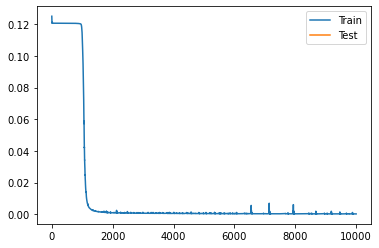

In [13]:
plt.plot(pinn.train_error, label="Train")
plt.plot(pinn.test_error, label="Test")
plt.legend()

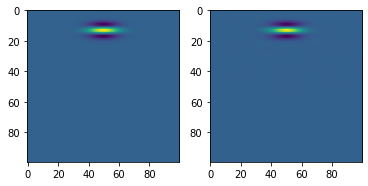

In [14]:
xs = np.linspace(0, 1, 100)
ts = np.linspace(0, 1, 100)
Xs, Ts = np.meshgrid(xs, ts)
X_plot = np.c_[Xs.flatten()[:, np.newaxis], Ts.flatten()[:, np.newaxis]]
F_label = source(X_plot).reshape(100, 100)
u_pred, F_pred = pinn.predict(X_plot)
F_pred = F_pred.reshape(100, 100)
u_pred = u_pred.reshape(100, 100)
plt.subplot(121)
plt.imshow(F_label)
plt.subplot(122)
plt.imshow(F_pred)

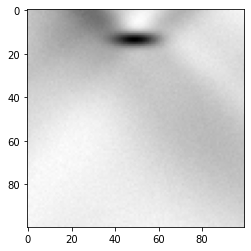

In [15]:
plt.imshow(u_pred, cmap="gray")

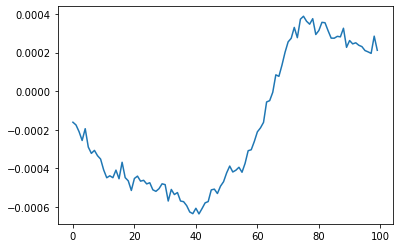

In [20]:
plt.plot(u_pred[18, :])